**Step 1. Clone the Mask R-CNN GitHub Repository**

In [1]:
import os
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


**Step 2: Install the Mask R-CNN Library**

In [2]:
%cd Mask_RCNN
!python setup.py install

/content/Mask_RCNN
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compi

**Step 3: Confirm the Library was Installed**

In [3]:
pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


In [4]:
!pip install -r /content/Mask_RCNN/requirements.txt

**Prepare a Dataset for Object Detection**

* In this tutorial, we will use the kangaroo dataset, made available by Huynh Ngoc Anh (experiencor). The dataset is comprised of 183 photographs that contain kangaroos, and XML annotation files that provide bounding boxes for the kangaroos in each photograph.

* The Mask R-CNN is designed to learn to predict both bounding boxes for objects as well as masks for those detected objects, and the kangaroo dataset does not provide masks. As such, we will use the dataset to learn a kangaroo object detection task, and ignore the masks and not focus on the image segmentation capabilities of the model.

* There are a few steps required in order to prepare this dataset for modeling and we will work through each in turn in this section, including downloading the dataset, parsing the annotations file, developing a KangarooDataset object that can be used by the Mask_RCNN library, then testing the dataset object to confirm that we are loading images and annotations correctly.

**Step 1: Install the Dataset**

In [5]:
%cd /content

/content


In [6]:
!ls

drive  kangaroo  Mask_RCNN  sample_data


In [7]:
!git clone https://github.com/experiencor/kangaroo.git

fatal: destination path 'kangaroo' already exists and is not an empty directory.


**Step 2: Parse Annotation File**

In [0]:
# load and parse the file
from xml.etree import ElementTree

# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
	# load and parse the file
	tree = ElementTree.parse(filename)
	# get the root of the document
	root = tree.getroot()
	# extract each bounding box
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	# extract image dimensions
	width = int(root.find('.//size/width').text)
	height = int(root.find('.//size/height').text)
	return boxes, width, height

In [9]:
# extract details form annotation file
boxes, w, h = extract_boxes('kangaroo/annots/00001.xml')
# summarize extracted details
print(boxes, w, h)

[[233, 89, 386, 262], [134, 105, 341, 253]] 450 319


**Step 3: Develop a Dataset Object**

In [10]:
%cd /content/Mask_RCNN/

from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

/content/Mask_RCNN


Using TensorFlow backend.


Train: 131
{'id': '00074', 'source': 'dataset', 'path': '/content/kangaroo/images/00074.jpg', 'annotation': '/content/kangaroo/annots/00074.xml'}


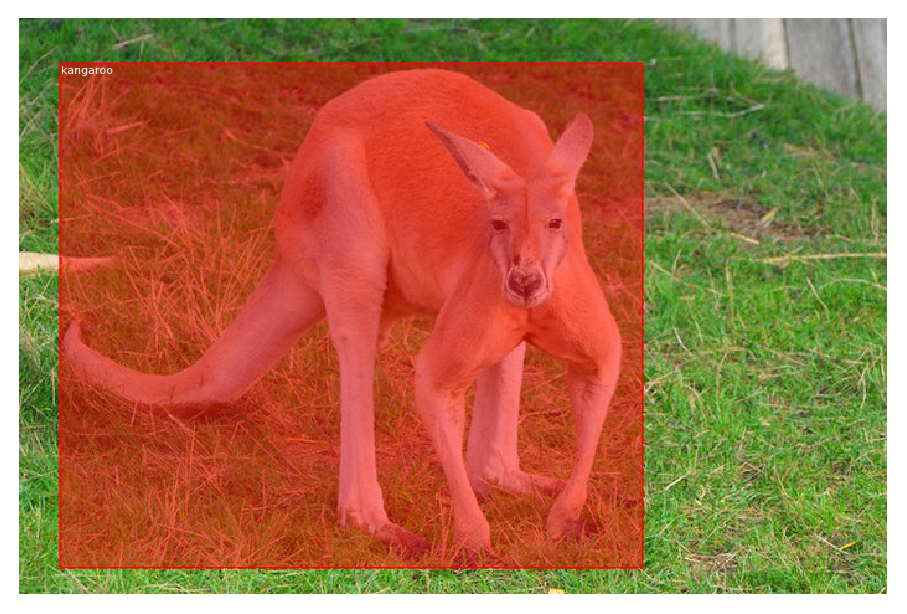

Test: 32


In [11]:
# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			#print(filename)
			#print(image_id)
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		print(info)
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = KangarooDataset()
train_set.load_dataset('/content/kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# define image id
image_id = 10
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

# test/val set
test_set = KangarooDataset()
test_set.load_dataset('/content/kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

**Create Model**

In [0]:
# define a configuration for the model
class KangarooConfig(Config):
	# Give the configuration a recognizable name
	NAME = "kangaroo_cfg"
	# Number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# Number of training steps per epoch
	STEPS_PER_EPOCH = 131

# prepare config
config = KangarooConfig()

In [13]:
#Create a model in Training mode
from mrcnn.model import MaskRCNN
model = MaskRCNN(mode='training', model_dir='./', config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The model will be used as-is, although the class-specific output layers will be removed so that new output layers can be defined and trained. This can be done by specifying the ‘exclude‘ argument and listing all of the output layers to exclude or remove from the model after it is loaded. This includes the output layers for the classification label, bounding boxes, and masks.

In [15]:
# load weights (mscoco)
model.load_weights('/content/drive/My Drive/Datasets/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

**Training**

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). In this case, we will only train the heads, that is the output layers of the model. To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.


In [16]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')


Starting at epoch 0. LR=0.0005

Checkpoint Path: ./kangaroo_cfg20191209T0346/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4        

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
{'id': '00151', 'source': 'dataset', 'path': '/content/kangaroo/images/00151.jpg', 'annotation': '/content/kangaroo/annots/00151.xml'}
{'id': '00151', 'source': 'dataset', 'path': '/content/kangaroo/images/00151.jpg', 'annotation': '/content/kangaroo/annots/00151.xml'}
{'id': '00044', 'source': 'dataset', 'path': '/content/kangaroo/images/00044.jpg', 'annotation': '/content/kangaroo/annots/00044.xml'}
{'id': '00044', 'source': 'dataset', 'path': '/content/kangaroo/images/00044.jpg', 'annotation': '/content/kangaroo/annots/00044.xml'}
{'id': '00158', 'source': 'dataset', 'path': '/content/kangaroo/images/00158.jpg', 'annotation': '/content/kangaroo/annots/00158.xml'}
{'id': '00158', 'source': 'dataset', 'path': '/content/kangaroo/images/00158.jpg', 'annotation': '/content/kangaroo/annots/00158.xml'}
{'id': '00075', 'source': 'dataset', 'path': '/content/kangaroo/images/00075.jpg', 'annotation': '/content/kangaroo/annots/00075.xml'}
{'id': '00075', 'source': 'dataset', 'path

In [0]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

In [18]:
# evaluate the mask rcnn model on the kangaroo dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import mean

# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# load model weights
model.load_weights('/content/Mask_RCNN/kangaroo_cfg20191209T0258/mask_rcnn_kangaroo_cfg_0001.h5', by_name=True)

# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 1
{'id': '00079', 'source': 'dataset', 'path': '/content/kangaroo/images/00079.jpg', 'annotation': '/content/kangaroo/annots/00079.xml'}
{'id': '00083', 'source': 'dataset', 'path': '/content/kangaroo/images/00083.jpg', 'annotation': '/content/kangaroo/annots/00083.xml'}
{'id': '00121', 'source': 'dataset', 'path': '/content/kangaroo/images/00121.jpg', 'annotation': '/content/kangaroo/annots/00121.xml'}
{'id': '00042', 'source': 'dataset', 'path': '/content/kangaroo/images/00042.jpg', 'annotation': '/content/kangaroo/annots/00042.xml'}
{'id': '00060', 'source': 'dataset', 'path': '/content/kangaroo/images/00060.jpg', 'annotation': '/content/kangaroo/annots/00060.xml'}
{'id': '00028', 'source': 'dataset', 'path': '/content/kangaroo/images/00028.jpg', 'annotation': '/content/kangaroo/annots/00028.xml'}
{'id': '00076', 'source': 'dataset', 'path': '/content/kangaroo/images/00076.jpg', 'annotation': '/content/kangar

**Test model performance on training photos**

In [0]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)#,figsize=(15,15))
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)#,figsize=(15,15))
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()

{'id': '00079', 'source': 'dataset', 'path': '/content/kangaroo/images/00079.jpg', 'annotation': '/content/kangaroo/annots/00079.xml'}
{'id': '00083', 'source': 'dataset', 'path': '/content/kangaroo/images/00083.jpg', 'annotation': '/content/kangaroo/annots/00083.xml'}
{'id': '00121', 'source': 'dataset', 'path': '/content/kangaroo/images/00121.jpg', 'annotation': '/content/kangaroo/annots/00121.xml'}
{'id': '00042', 'source': 'dataset', 'path': '/content/kangaroo/images/00042.jpg', 'annotation': '/content/kangaroo/annots/00042.xml'}
{'id': '00060', 'source': 'dataset', 'path': '/content/kangaroo/images/00060.jpg', 'annotation': '/content/kangaroo/annots/00060.xml'}


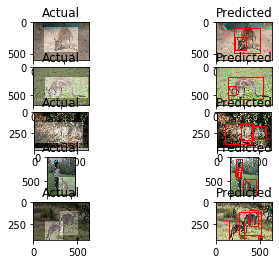

{'id': '00179', 'source': 'dataset', 'path': '/content/kangaroo/images/00179.jpg', 'annotation': '/content/kangaroo/annots/00179.xml'}
{'id': '00155', 'source': 'dataset', 'path': '/content/kangaroo/images/00155.jpg', 'annotation': '/content/kangaroo/annots/00155.xml'}
{'id': '00156', 'source': 'dataset', 'path': '/content/kangaroo/images/00156.jpg', 'annotation': '/content/kangaroo/annots/00156.xml'}
{'id': '00173', 'source': 'dataset', 'path': '/content/kangaroo/images/00173.jpg', 'annotation': '/content/kangaroo/annots/00173.xml'}
{'id': '00177', 'source': 'dataset', 'path': '/content/kangaroo/images/00177.jpg', 'annotation': '/content/kangaroo/annots/00177.xml'}


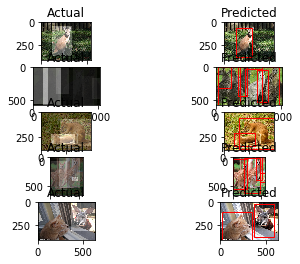

In [20]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)

**Test with online photos**

kangaroo3.jpg


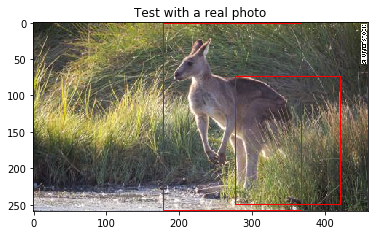

kangaroo4.jpg


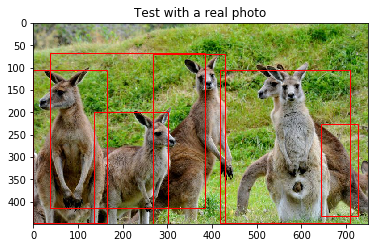

kangaroo2.jpg


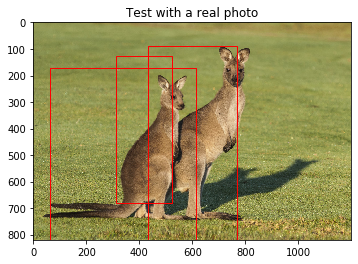

red_kangaroo-24c18ab08dc145f1a798abd4b820390a.jpg


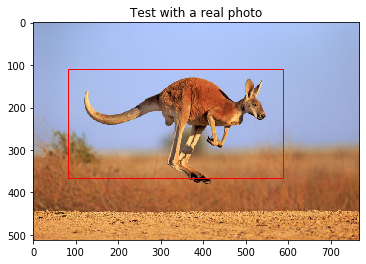

cristiano3.jpg


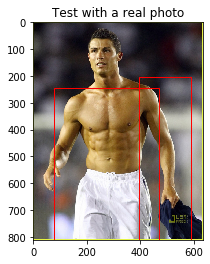

cristiano2.jpg


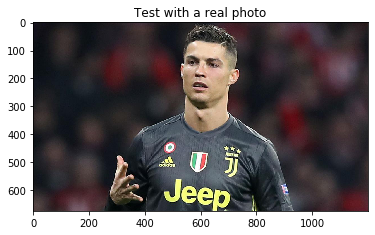

cristiano.jpg


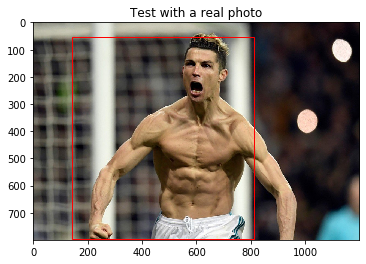

In [21]:
import skimage.color
import skimage.io
import skimage.transform

sample_dir = '/content/drive/My Drive/Datasets/sample'

# Load all images
for sample_img in listdir(sample_dir):
    print(sample_img)
    my_image = skimage.io.imread(sample_dir+'/'+sample_img)#(self.image_info[image_id]['path'])
    # If grayscale. Convert to RGB for consistency.
    if my_image.ndim != 3:
        my_image = skimage.color.gray2rgb(my_image)
    # If has an alpha channel, remove it for consistency
    if my_image.shape[-1] == 4:
        my_image = my_image[..., :3]

    # convert pixel values (e.g. center)
    scaled_image = mold_image(my_image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]

    pyplot.imshow(my_image)
    pyplot.title('Test with a real photo')
    ax = pyplot.gca()
    # plot each box
    for box in yhat['rois']:
	        # get coordinates
	        y1, x1, y2, x2 = box
	        # calculate width and height of the box
	        width, height = x2 - x1, y2 - y1
	        # create the shape
	        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
	        # draw the box
	        ax.add_patch(rect)
    # show the figure
    pyplot.show()        